In [5]:
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
import networkx as nx
import gym 
from tqdm import tqdm 
from collections import deque
rng = np.random.RandomState(2025)

In [95]:
class Node:
    def __init__(self, name, parent=None, mean=0, var=1):
        self.name = name
        self.mean = mean  
        self.var = var  
        self.children = []
        self.scores_children = np.array([])
        self.nb_children = 0
        self.parent = parent
        self.level = parent.level + 1 if parent else 0
        self.value = self.get_reward()

    def get_child_nodes(self):
        if not nodes:
            nodes = []
        for child in self.children:
            nodes.append((child.name, child.level, child.nb_children))
            nodes.extend(child.get_child_nodes())
        return nodes

    def get_reward(self):
        return self.mean + np.sqrt(self.var) * np.random.normal()



class Tree:
    def __init__(self):
        self.levels = [[]]
        self.graph = {'root': None,}
        self.max_level = 0

    def create_node(self, name, parent=None, mean=0, var=1):
        return Node(name, parent, mean, var)

    def insert(self, parent_node, name, mean, var):
        if parent_node is None:
            node = self.create_node(name, mean=mean, var=var)
            if node.level == 0:
                self.root = node
                value = node.get_reward()
                self.graph['root'] = node
            return node

        node = self.create_node(name, parent_node, mean, var)
        value = node.get_reward()
        self.graph[name] = node
        parent_node.children.append(node)
        parent_node.nb_children = len(parent_node.children)
        parent_node.scores_children = np.full(parent_node.nb_children, 1.0 / parent_node.nb_children)
        self.max_level = max(self.max_level, node.level)
        return node, parent_node

    def get_parent_nodes(self, node):
        nodes = [node]
        def _recursive_parent_nodes(node, nodes):
            if node.parent:
                nodes.append(node.parent)
                _recursive_parent_nodes(node.parent, nodes)
            return nodes
        nodes = _recursive_parent_nodes(node, nodes)
        nodes.reverse()
        return nodes

    def get_all_nodes(self):
        nodes = [self.root]
        def _get_nodes(node):
            for child in node.children:
                nodes.append(child)
                _get_nodes(child)
        _get_nodes(self.root)
        nodes = sorted(nodes, key=lambda node: node.level)
        nodes_names = [node.name for node in nodes]
        return nodes

    def get_all_leaves(self):
        leaves = []
        def get_leaves(node):
            if len(node.children) == 0:
                leaves.append(node)
            if node is not None:
                for child in node.children:
                    get_leaves(child)
        get_leaves(self.root)
        return leaves

    def get_reward_leaf(self, leaf):
        parents_leaf = self.get_parent_nodes(leaf)
        reward = 0 
        for node in parents_leaf:
            reward += node.value
        return reward
    
    def get_reward_leaves(self):
        leaves = self.get_all_leaves()
        data = []
        for leaf in leaves:
            data.append([leaf, leaf.name, self.get_reward_leaf(leaf)])
        return data


    def iterative_dfs(self, node_key=None):
        if not node_key:
            node_key = 'root'
        visited = []
        stack = deque()
        stack.append(node_key)
        while stack:
            node_key = stack.pop()
            if node_key not in visited:
                visited.append(node_key)
                unvisited = [n.name for n in self.graph[node_key].children if n.name not in visited]
                stack.extend(unvisited)
        return visited

    def iterative_bfs(self, start=None):
        if not start:
            start = 'root'
        visited = []
        queue = deque()
        queue.append(start)
        while queue:
            node_key = queue.popleft()
            if node_key not in visited:
                visited.append(node_key)
                unvisited = [n.name for n in self.graph[node_key].children if n.name not in visited]
                queue.extend(unvisited)
        return visited

    def find_best_arm_path(self):
        data = self.get_reward_leaves()
        best_leaf_index = np.argmax([x[2] for x in data])
        best_leaf, _, _ = data[best_leaf_index]
        path_nodes = self.get_parent_nodes(best_leaf)
        path_rewards = [node.value for node in path_nodes]
        path_names = [node.name for node in path_nodes]
        return path_nodes
    
    def visualize_tree(self):
        G = nx.DiGraph()
        labels = {}
        edge_labels = {}
        pos = {}
        node_colors = []

        def add_edges(node, pos_x=0, pos_y=0, layer_width=1.0):
            G.add_node(node.name)
            labels[node.name] = node.name
            pos[node.name] = (pos_x, -pos_y)
            node_colors.append(node.level)

            num_children = len(node.children)
            width_step = layer_width / max(num_children, 1)

            for i, child in enumerate(node.children):
                reward = child.value
                G.add_edge(node.name, child.name)
                edge_labels[(node.name, child.name)] = f"{reward:.2f}"

                child_x = pos_x - layer_width / 2 + (i + 0.5) * width_step
                add_edges(child, child_x, pos_y + 1, width_step)

        add_edges(self.root)
        for node in self.get_all_nodes():
            if len(node.children) == 0:  
                total_reward = self.get_reward_leaf(node)
                labels[node.name] = f"{node.name}\n({total_reward:.2f})"

        cmap = plt.cm.viridis
        colors = [cmap(l / (self.max_level + 1)) for l in node_colors]
        plt.figure(figsize=(14, 8))
        nx.draw(
            G, pos, labels=labels, node_color=colors,
            with_labels=True, node_size=2000, font_size=10, font_color='white'
        )
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=self.max_level))
        sm.set_array([])
        cbar = plt.colorbar(sm, ticks=range(self.max_level + 1))
        cbar.ax.set_yticklabels([f"Level {i}" for i in range(self.max_level + 1)])
        plt.title("Environment")
        plt.axis('off')
        plt.show()

In [ ]:
def generate_tree():
    tree = Tree()
    root = tree.insert(parent_node=None, name="Utilisateur", mean=0, var=0)

    # First Layer
    vehicule, _ = tree.insert(parent_node=root, name="vehicule", mean=0.8, var=2)
    mob_verte, _ = tree.insert(parent_node=root, name="Mobilités Vertes", mean=2, var=2)

    # Second Layer
    taxi, _ = tree.insert(parent_node=vehicule, name="taxi", mean=0.1, var=2)
    uber, _ = tree.insert(parent_node=vehicule, name="uber", mean=0.2, var=2)
    bus, _ = tree.insert(parent_node=vehicule, name="bus", mean=0.05, var=2)
    tram, _ = tree.insert(parent_node=vehicule, name="tram", mean=0.3, var=2)
    covoiturage, _ = tree.insert(parent_node=vehicule, name="covoiturage", mean=0.2, var=2)
    avion, _ = tree.insert(parent_node=vehicule, name="avion", mean=0.1, var=2)
    train, _ = tree.insert(parent_node=vehicule, name="train", mean=0.4, var=2)
    rer, _ = tree.insert(parent_node=vehicule, name="RER", mean=0.3, var=2)
    metro, _ = tree.insert(parent_node=vehicule, name="métro", mean=0.1, var=2)

    velo, _ = tree.insert(parent_node=mob_verte, name="vélo", mean=1.5, var=2)
    marche, _ = tree.insert(parent_node=mob_verte, name="marche", mean=1.0, var=2)
    cap, _ = tree.insert(parent_node=mob_verte, name="course à pied", mean=2.5, var=2)
    return tree

tree = generate_tree()

print("\n--- All the nodes in the Tree ---")
all_nodes = tree.get_all_nodes()
for node in all_nodes:
    print(f"Name: {node.name}, Drawing reward: {node.value:.4f}, Level: {node.level}")

print("\n--- Leaves of the Tree ---")
data = tree.get_reward_leaves()
for elements in data:
    name = elements[1]
    reward = elements[2]
    print(f"Name: {name}, Drawing reward: {reward:.4f}")

print("\n--- Path with the maximum reward ---")
best_path = tree.find_best_arm_path()
print(f"Max sum : {np.sum([node.value for node in best_path]):.4f}")
print(f"Rewards: {' -> '.join([str(node.value) for node in best_path])}")
print(f"Path: {' -> '.join([str(node.name) for node in best_path])}")


--- All the nodes in the Tree ---
Name: Utilisateur, Drawing reward: 0.0000, Level: 0
Name: vehicule, Drawing reward: 1.8262, Level: 1
Name: Mobilités Vertes, Drawing reward: 1.6641, Level: 1
Name: taxi, Drawing reward: 2.0734, Level: 2
Name: uber, Drawing reward: 0.7088, Level: 2
Name: bus, Drawing reward: 0.5720, Level: 2
Name: tram, Drawing reward: 2.0603, Level: 2
Name: covoiturage, Drawing reward: 0.6427, Level: 2
Name: avion, Drawing reward: 0.2644, Level: 2
Name: train, Drawing reward: 0.9192, Level: 2
Name: RER, Drawing reward: -2.6218, Level: 2
Name: métro, Drawing reward: 2.1118, Level: 2
Name: vélo, Drawing reward: -0.5591, Level: 2
Name: marche, Drawing reward: 0.8166, Level: 2
Name: course à pied, Drawing reward: 2.0020, Level: 2

--- Leaves of the Tree ---
Name: taxi, Drawing reward: 3.8996
Name: uber, Drawing reward: 2.5350
Name: bus, Drawing reward: 2.3982
Name: tram, Drawing reward: 3.8865
Name: covoiturage, Drawing reward: 2.4689
Name: avion, Drawing reward: 2.0906
N

/var/folders/9x/48xzc29960x71dmw5lhg1xz80000gn/T/ipykernel_8622/3149488775.py:178: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=range(self.max_level + 1))


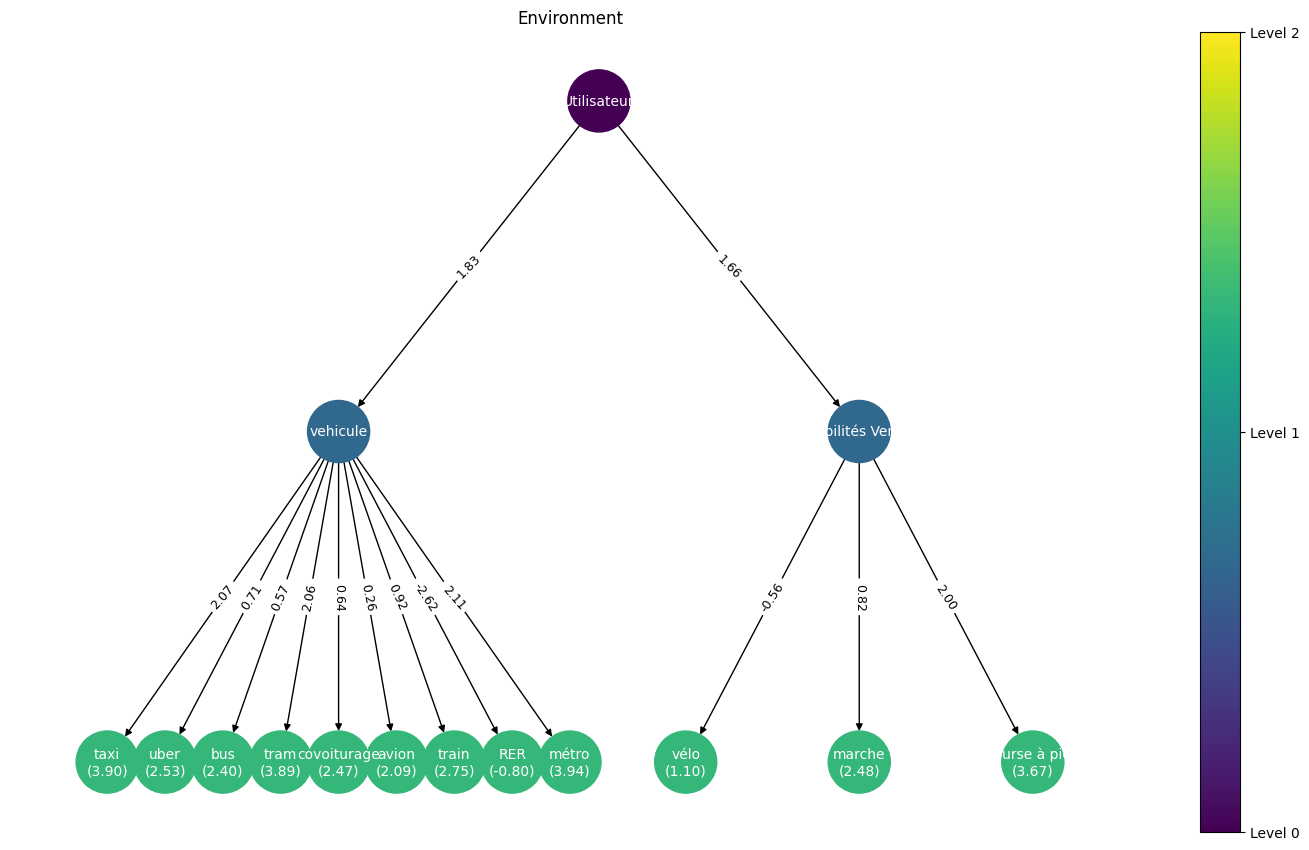

In [97]:
tree.visualize_tree()

In [98]:
class StochasticEnvironment(gym.Env):
    def __init__(self, mus):
        self.mus = mus
        self.var = 2
        self.generate_tree()
        
    def reset(self):
        self.generate_tree()
    

    def generate_tree(self):
        tree = Tree()
        var = 2
        root = tree.insert(parent_node=None, name="Utilisateur", mean=0, var=0)

        # First Layer
        mu_layer1 = self.mus[0]
        vehicule, _ = tree.insert(parent_node=root, name="vehicule", mean=mu_layer1[0], var=var)
        mob_verte, _ = tree.insert(parent_node=root, name="Mobilités Vertes", mean=mu_layer1[1], var=var)

        # Second Layer
        mu_layer2 = self.mus[1]
        mu_layer2_1 = mu_layer2[0]
        taxi, _ = tree.insert(parent_node=vehicule, name="taxi", mean=mu_layer2_1[0], var=var)
        uber, _ = tree.insert(parent_node=vehicule, name="uber", mean=mu_layer2_1[1], var=var)
        bus, _ = tree.insert(parent_node=vehicule, name="bus", mean=mu_layer2_1[2], var=var)
        tram, _ = tree.insert(parent_node=vehicule, name="tram", mean=mu_layer2_1[3], var=var)
        covoiturage, _ = tree.insert(parent_node=vehicule, name="covoiturage", mean=mu_layer2_1[4], var=var)
        avion, _ = tree.insert(parent_node=vehicule, name="avion", mean=mu_layer2_1[5], var=var)
        train, _ = tree.insert(parent_node=vehicule, name="train", mean=mu_layer2_1[6], var=var)
        rer, _ = tree.insert(parent_node=vehicule, name="RER", mean=mu_layer2_1[7], var=var)
        metro, _ = tree.insert(parent_node=vehicule, name="métro", mean=mu_layer2_1[8], var=var)

        mu_layer2_2 = mu_layer2[1]
        velo, _ = tree.insert(parent_node=mob_verte, name="vélo", mean=mu_layer2_2[0], var=var)
        marche, _ = tree.insert(parent_node=mob_verte, name="marche", mean=mu_layer2_2[1], var=var)
        cap, _ = tree.insert(parent_node=mob_verte, name="course à pied", mean=mu_layer2_2[2], var=var)
        
        self.tree = tree

        return tree
    
    def get_action_set(self):
        return self.tree.get_all_leaves()
    
    def get_reward(self, leaf):
        return self.tree.get_reward_leaf(leaf)
    
    def get_best_strategy_reward(self):
        best_arm_path =  self.tree.find_best_arm_path()
        return [node.name for node in best_arm_path] ,np.sum([node.value for node in best_arm_path])

    def step(self, leaf):
        reward = self.get_reward_leaf(leaf)
        done = True  
        return [0], reward, done, {}
    
    def render(self, mode='human', close=False):
        pass

In [99]:
env = StochasticEnvironment()
tree = env.reset()
env.get_reward()

TypeError: __init__() missing 1 required positional argument: 'mus'

In [ ]:
def play(environment, agent, Nmc, T):
    """
    Simulate multiple trajectories of agent-environment interaction and record regret.

    This function simulates the interaction between a single agent and an environment 
    over Nmc independent trajectories, each lasting T rounds. It records the pseudo-regret 
    at each time step by comparing the received reward to the best possible reward.

    Parameters
    ----------
    environment : object
        The environment in which the agent operates. 

    agent : object
        The agent being evaluated. 

    Nmc : int
        Number of Monte Carlo trajectories to simulate.

    T : int
        Time horizon (number of steps per trajectory).

    Returns
    -------
    agent_id : str
        The name or identifier of the agent (via `agent.name()`).

    data : np.ndarray
        A NumPy array of shape (Nmc, T), where each entry contains the pseudo-regret 
        (best possible reward minus received reward) at time t in trajectory n.

    Notes
    -----
    The pseudo-regret at each time step is computed using the current mean rewards
    of the environment arms, which assumes those are fixed and known for evaluation.
    """
    # Initialize the regret matrix
    data = np.zeros((Nmc, T))

    # Loop over each independent trajectory
    for n in range(Nmc):
        environment.reset()  # Reset environment if needed (i.i.d. or not)
        agent.reset()        # Reset internal state of the agent

        for t in range(T):
            # Get available actions and let agent choose one
            action_set = environment.get_action_set()
            action = agent.get_action(action_set)

            # Get reward for the chosen action and send it back to the agent
            reward = environment.get_reward(action)
            agent.receive_reward(action, reward)

            # Compute pseudo-regret: best mean - received reward
            means = environment.get_means()
            best_reward = np.max(means)
            data[n, t] = best_reward - reward

    return agent.name(), data


In [ ]:
def experiment(environment, agents, Nmc, T):
    """
    Run multiple simulations of each agent interacting with the environment and record regret.

    This function evaluates a list of agents by having them interact with a given environment
    over multiple Monte Carlo simulations, each lasting for a fixed time horizon.
    For each agent, it computes and stores the regret over time for each trajectory.

    Parameters
    ----------
    environment : object
        The environment in which the agents operate. 
    
    agents : list
        A list of agent instances. Each agent must implement `reset()`, `get_action()`,
        `receive_reward(action, reward)`, and `name()` methods.
    
    Nmc : int
        Number of Monte Carlo simulations to run for each agent.
    
    T : int
        Time horizon (number of rounds) for each simulation.

    Returns
    -------
    all_data : dict
        A dictionary mapping each agent's name (str) to a NumPy array of shape (Nmc, T),
        containing the regret at each time step for each Monte Carlo run.
    """
    all_data = {}

    for agent in agents:
        # Run Nmc simulations for the current agent and compute regrets
        agent_id, regrets = play(environment, agent, Nmc, T)

        # Store the results in the dictionary under the agent's name
        all_data[agent_id] = regrets

    return all_data

In [ ]:
class StochasticEnvironment(gym.Env):
    """
    The Environment class represents a decision-making environment with a tree structure.
    The tree is generated dynamically and rewards are assigned to each node based on its level and value. 
    The environment allows the computation of rewards based on nodes and paths, 
    and finds the best strategy for decision-making.

    Attributes
    ----------
    env_rng : numpy.random.RandomState
        A random state generator used for sampling rewards.
    
    nb_layers : int 
        Number of layers for the Tree. 
        Example 3 

    nb_nodes_per_layer : list
        Number of nodes per layer for the Tree. 
        Example [1, 2, 5]

    mus : list
        Mean of the distribution for each layer. 
        Example [0, [1, 4], [[0.1, 0.3], [0.2, 0.1, 0.1]]]
    
    """ 
    def __init__(self, nb_nodes_per_layer, mus):
        self.env_rng = np.random.RandomState(2025)  # Use a fixed seed for reproducibility
        self.nb_layers = len(nb_nodes_per_layer) 
        self.nb_nodes_per_layer = nb_nodes_per_layer
        self.mus = mus
        self.sigma = 1

    def reset(self):
        self.tree = Tree()
        self.generate_tree()
        return [0]
    
    def _initialize_tree(self):
        """
        Initializes the tree by creating the root node.
        """
        self.root = None
        self.tree = Tree()
        self.root = self.tree.insert(self.root, ('root', self.mus[0])) 

    def generate_tree(self):
        self._initialize_tree()

        def build_layer(parents, mus_layer, layer_idx):
            current_layer_nodes = []

            if len(parents) != len(mus_layer):
                raise ValueError(f"Layer {layer_idx}: expected {len(parents)} parents, got {len(mus_layer)} mus sublists")
            
            for parent_idx, (parent_node, child_mus_list) in enumerate(zip(parents, mus_layer)):
                if not isinstance(child_mus_list, list):
                    raise ValueError(f"Layer {layer_idx}: mus[{layer_idx}][{parent_idx}] should be a list of floats")

                for child_idx, mu in enumerate(child_mus_list):
                    value = self.env_rng.normal(mu, self.sigma)
                    node_data = (f"Node_{layer_idx}_{parent_idx}_{child_idx}", value)
                    node, _ = self.tree.insert(parent_node, node_data)
                    current_layer_nodes.append(node)
            return current_layer_nodes

        if not isinstance(self.mus[0], (int, float)):
            raise ValueError("mus[0] must be a scalar for root node.")
        self.root.data = ("root", self.env_rng.normal(self.mus[0], self.sigma))

        parents = [self.root]

        for layer_idx in range(1, len(self.mus)):
            mus_layer = self.mus[layer_idx]

            if layer_idx == 1:
                current_layer_nodes = []
                for idx, mu in enumerate(mus_layer):
                    value = self.env_rng.normal(mu, self.sigma)
                    node_data = (f"Node_{layer_idx}_{idx}", value)
                    node, _ = self.tree.insert(self.root, node_data)
                    current_layer_nodes.append(node)
                parents = current_layer_nodes
            else:
                parents = build_layer(parents, mus_layer, layer_idx)

        return self.tree
    
    def get_action_set(self):
        return list(np.arange(len(self.tree.get_all_nodes())))
    
    def get_reward(self, action):
        """Obtain the reward given an action."""
        # The action is a path, with indexes corresponding to the nodes 
        node = self.tree.graph.get(action)
        if node:
            total_reward = 0
            path_node = node
            while path_node:
                total_reward += path_node.get_reward()
                path_node = path_node.parent
            return total_reward
        return 0
    
    def get_best_strategy_reward(self):
        all_rewards = [node.mean for node in self.tree.get_all_nodes()]
        return np.max(all_rewards)

    def get_reward_by_node(self, node):
        return node.get_reward()
    
    def step(self, action):
        reward = self.get_reward(action)
        done = True  
        return [0], reward, done, {}
    
    def render(self, mode='human', close=False):
        pass

    
    def visualize_tree(self):
        G = nx.DiGraph()

        def add_edges(node, parent_name=None):
            if node is not None:
                G.add_node(node.name, level=node.level) 
                if parent_name:
                    G.add_edge(parent_name, node.name)  
                for child in node.children:  
                    add_edges(child, node.name)

        add_edges(self.tree.root)
        

        color_map = plt.cm.get_cmap("viridis", self.tree.max_level + 1)
        levels = [G.nodes[node]['level'] for node in G.nodes]
        norm = plt.Normalize(vmin=min(levels), vmax=max(levels))
        node_colors = [color_map(norm(G.nodes[node]['level'])) for node in G.nodes]
        pos = nx.spring_layout(G, seed=2025)  
        labels = nx.get_node_attributes(G, 'label')
        nx.draw(G, pos, with_labels=True, node_size=3000, node_color=node_colors, font_size=10, font_weight='bold')
        sm = plt.cm.ScalarMappable(cmap=color_map, norm=norm)
        sm.set_array([])
        level_labels = [f"Couche {i}" for i in range(self.tree.max_level + 1)]
        cbar = plt.colorbar(sm, shrink=2, aspect=2)
        cbar.set_ticks(np.linspace(0, 1, self.tree.max_level + 1))  
        cbar.set_ticklabels(level_labels)  
        
        plt.show()